Using cache found in /Users/zubairfaruqui/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/miniconda3/envs/zConda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/zConda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicting for image: ./ImageNetPics/ImageNetImage6.JPEG
Top 5 predictions:
jean: 0.6308
wig: 0.0159
cowboy hat: 0.0143
mask: 0.0100
ski mask: 0.0086


  0%|          | 0/1000 [00:00<?, ?it/s]

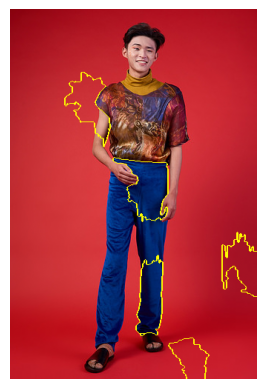


Predicting for image: ./ImageNetPics/ImageNetImage7.JPEG
Top 5 predictions:
snail: 0.4498
acorn: 0.4278
slug: 0.0061
leaf beetle: 0.0050
fig: 0.0046


  0%|          | 0/1000 [00:00<?, ?it/s]

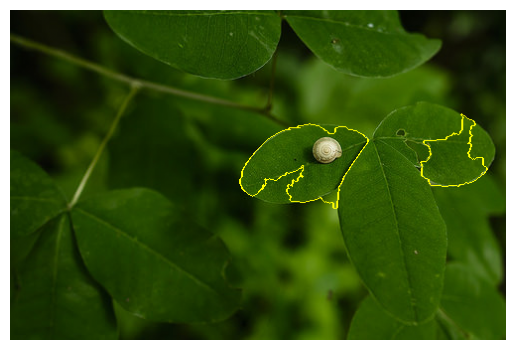


Predicting for image: ./ImageNetPics/ImageNetImage1.JPEG
Top 5 predictions:
laptop: 0.7787
notebook: 0.1197
doormat: 0.0054
web site: 0.0046
bookshop: 0.0028


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
import torch
from PIL import Image
from torchvision import transforms
import os
import urllib
import matplotlib.pyplot as plt
import time

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()  # Set the model to evaluation mode as we are only performing inference


preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


filename1 = 'imagenet_classes.txt'

# Check if the class label file exists locally, if not download it
if not os.path.exists(filename1):
    filename1 = urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt',
        filename1
    )[0]

# Read and store the class labels
with open(filename1, "r") as f:
    categories = [s.strip() for s in f.readlines()]



image_folder = './ImageNetPics'  # Replace with your folder path

image_paths = [os.path.join(image_folder, fname)
               for fname in os.listdir(image_folder)
               if fname.endswith(('.jpg', '.jpeg', '.png', '.JPEG'))]


from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np


def predict_image_with_lime(image_path):
    # Load and preprocess the image
    input_image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB mode

    # Preprocess the image
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU for speed if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_batch = input_batch.to(device)
    model.to(device)

    # Get the model's predictions
    with torch.no_grad():
        output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    print("Top 5 predictions:")
    for i in range(top5_prob.size(0)):
        print(f"{categories[top5_catid[i]]}: {top5_prob[i].item():.4f}")

    # Convert the input image to a NumPy array (for LIME)
    input_image_np = np.array(input_image)

    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Define a prediction function that operates on the GPU
    def predict_fn(images):
        batch = torch.stack([preprocess(Image.fromarray(image)) for image in images])
        batch = batch.to(device)
        with torch.no_grad():
            outputs = model(batch)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        return probabilities

    # Get LIME explanation for the top class
    explanation = explainer.explain_instance(input_image_np, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

    # Get the explanation for the top class
    temp, mask = explanation.get_image_and_mask(top5_catid[0].item(), positive_only=True, num_features=5, hide_rest=False)

    # Display the image with LIME explanation
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')  # Hide the axis for better visualization
    plt.show()



import shap
import torch
from PIL import Image
from torchvision import transforms
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np
# Function to predict and explain with SHAP
def predict_image_with_shap(image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load and preprocess the image
    input_image = Image.open(image_path).convert('RGB')

    # Display the image
    plt.imshow(input_image)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    input_tensor = preprocess(input_image).unsqueeze(0).to(device)

    # Get the model's predictions
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    # Display top-5 predictions
    print("Top 5 predictions:")
    for i in range(top5_prob.size(0)):
        print(f"{categories[top5_catid[i]]}: {top5_prob[i].item():.4f}")

    # Use SHAP to explain the top class
    background = torch.cat([input_tensor] * 10).to(device)  # Create a small batch for background
    explainer = shap.DeepExplainer(model, background)

    # SHAP requires the input to be a batch, so we provide the batch of images
    shap_values = explainer.shap_values(input_tensor)

    # Convert to NumPy and plot the SHAP explanation for the top class
    shap_numpy = shap_values[0][0].cpu().numpy()
    shap.image_plot([shap_numpy], np.array(input_image))


for image_path in image_paths:
    print(f"Predicting for image: {image_path}")

    try:
        # predict_image_with_shap(image_path)
         predict_image_with_lime(image_path)
    except Exception as e:
        print(f"An error occurred with image {image_path}: {e}")

    print()  # Add space between predictions for clarity
